run

In [ ]:
!git clone https://github.com/radhikasethi2011/btechproj.git

Cloning into 'btechproj'...
remote: Enumerating objects: 315, done.
remote: Counting objects: 100% (315/315), done.
remote: Compressing objects: 100% (262/262), done.
remote: Total 315 (delta 125), reused 135 (delta 40), pack-reused 0
Receiving objects: 100% (315/315), 20.71 MiB | 7.83 MiB/s, done.
Resolving deltas: 100% (125/125), done.


functional code for generating multiple bed files

run

In [ ]:
import pandas as pd 
import numpy as np
#flag=1 -> tad file 
#flag=2 -> left boundry file 
#flag=3 -> rightboundry file 


def bed_file(df, flag,name,shift):
  if flag==1:
    #tad
    tad = (df['chr1_num'] + df['chr2_num']) / 2
    df2 = tad.to_frame()
    df2 = df2.astype('int')
    left = df2[0] - shift 
    left.to_frame()
    right = df2[0] + shift 
    right.to_frame()
    chrom_num = df['chromosome_num']
    df = df.join(left).rename(columns={0: 'left'})
    df = df.join(right).rename(columns={0: 'right'})
    df['.'] = df['chromosome_num'] + str(':') + df['left'].astype('str') + str('-') + df['right'].astype(str)

  elif flag==2:
    #left
    lbx = (df['chr1_num'] - shift-200 )
    lbx=lbx.to_frame()
    lbx=lbx.rename(columns={'chr1_num':'LeftBoundaryX'})
    df=df.join(lbx)
    lby = (df['chr1_num'] - shift )
    lby=lby.to_frame()
    lby=lby.rename(columns={'chr1_num':'LeftBoundaryY'})
    df=df.join(lby)
    df['.'] = df['chromosome_num'] + str(':') +df['LeftBoundaryX'].astype('str') + str('-') + df['LeftBoundaryY'].astype(str)

  elif flag==3:
    #right
    rbx = (df['chr2_num'] + shift )
    rbx=rbx.to_frame()
    rbx=rbx.rename(columns={'chr2_num':'RightBoundaryX'})
    df=df.join(rbx)
    rby = (df['chr2_num'] + shift + 200 )
    rby=rby.to_frame()
    rby=rby.rename(columns={'chr2_num':'RightBoundaryY'})
    df=df.join(rby)
    df['.'] = df['chromosome_num'] + str(':') +df['RightBoundaryX'].astype('str') + str('-') + df['RightBoundaryY'].astype(str)

  else: 
    print("error")
    return
  df = df.drop(columns=['chr1_num','chr2_num'])
  df.to_csv(name + '.bed', header = None, index=None, sep='\t')

code for converting fasta files to our siutable files for running markov models

run

In [ ]:
!pip install Bio

     |████████████████████████████████| 271 kB 12.1 MB/s 
     |████████████████████████████████| 2.3 MB 40.7 MB/s 


run


In [ ]:
from re import A
from Bio import SeqIO
import pandas as pd

def fasta_to_dataframe(bound,name, file1):
  with open(file1) as fasta_file:  # Will close handle cleanly
    identifiers = []
    seqs = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        seqs.append(str(seq_record.seq))

    data= {'EventId':identifiers,'seq':seqs}
    df=pd.DataFrame(data)
    df['FoldID'] ='A'
    df['start_index']='-5'
    df=df[["FoldID","EventId","start_index","seq"]] #ordering the columns
    df['seq']=df['seq'].str.upper()
    df['Bound'] =bound
    df.to_csv(name + '.txt', index=None, sep='\t')
    return df

merge

In [ ]:
def mixed(dfs):
 df_final1 = pd.concat( dfs,ignore_index=True)
 return df_final1

reverse and replace characters in strings

In [ ]:
def complement1(df_final):
  df_final['seq'] = df_final.loc[:,'seq'].apply(lambda x: x[::-1])
  df_final['seq'] = df_final['seq'].str.replace("A","1")
  df_final['seq']= df_final['seq'].str.replace("T","A")
  df_final['seq']= df_final['seq'].str.replace("1","T")

  df_final['seq']=df_final['seq'].str.replace("C","2")
  df_final['seq']=df_final['seq'].str.replace("G","C")
  df_final['seq']= df_final['seq'].str.replace("2","G")
  return df_final

shuffle divide

In [ ]:
import numpy as np

def shuffle_divide(df_final):
  df_final = df_final.sample(frac = 1)
  partitions = 2
  dfs_partition = np.array_split(df_final, partitions)
  return dfs_partition

Code for running markkov models 

1. Left boundry and tads


run

In [ ]:
import random
import random
import string
import numpy as np
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', None)
import copy
import math
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
import pylab as pl
from sklearn import metrics
from sklearn.model_selection import KFold
import os 
import seaborn as sns




def get_num(a, b, x):
    """
    gets a unique number between a range (a,b), divisible by x
    input:  a - start inde
            b - end index
            x = random number should be divisible by x
    return:
        random number divisible by x
    """
    if not a % x:
        return random.choice(range(a, b, x))
    else:
        return random.choice(range(a + x - (a % x), b, x))

def motif_string():
    """
    generates a string of length (by get_num) of ACGT
    returns: string of equal ACGT
    """
    length = 288
    # print("random length: " , length)
    len4 = length / 4
    # print("len / 4 :" , len4)
    letters = ["A", "C", "G", "T"]
    letters_list = list(random.choice(letters))
    random.shuffle(letters_list)
    # print(" Random generated string with repetition:")
    str1 = ""
    return str1.join(letters_list)

def non_motif_string(length):
    """
    generates a string of length (by get_num) of ACGT
    returns: string 
    """
    # print("random length: " , length)
    #len4 = length / 4
    # print("len / 4 :" , len4)
    letters = ["A", "C", "G", "T"]
    nonmotiflist = []
    for i in range(length): 
      nonmotiflist.append(random.choice(letters))
    # print(" Random generated string with repetition:")
    str1 = ""
    return str1.join(nonmotiflist)

def add_motif():
    """
    adds a motif - string input, to output by non_motif_string
    returns: string consisting of a motif
    """
    motif = 'ATACGTTACCCG'
    result = list(motif_string())
    i = random.choice(range(len(result)))
    result.insert(i, motif)
    result = "".join(result)
    return result,i


def write_to_df(length,var): #to generate non motif background files
  l=[]
  for i1 in range(int(length)):
    l1=[]
    i=-5
    result= non_motif_string(var)
    seq = "seq_" + str(i1 + 1) + "_peak"
    a='0'      
    l1 = ["A",seq,str(i), result,a]
    l.append(list(l1))
  df = pd.DataFrame(l,columns=['FoldID',	'EventID',	'start_index',	'seq',	'Bound']) 
  return df


def read_pfm_jaspar(filepath_):
  with open(Path(filepath_)) as f:
    lines = f.readlines()

  a = []
  for i in range(1,5,1):
    b = list(lines[i].split()[2:-1])
    a.append(b)
  a = np.array(a,dtype=float)
  return a

def convert_pfm_to_ppm(pfm):
  for i in range(pfm.shape[1]):
    sum = 0
    for j in range(pfm.shape[0]):
      sum+= pfm[j][i] 
    for j in range(pfm.shape[0]):
      prob = float(pfm[j][i]/sum)
      ppm[j][i] = float(prob)
  return(ppm)


p1=['A','C','G','T']
str1=''
def ppm_to_motif(ppm):
  motif = []
  mot=[]
  for i in range(ppm.shape[1]):
    arr = []
    for j in range(ppm.shape[0]):
      arr.append(float(ppm[j][i]))
    choice = np.random.choice(p1,p=arr) #motif is generated here
    mot.append(choice)
  
  return (''.join(mot))

def non_motif_create(df1,df2): #to implant a  motif in a non motif file -> 1. motif file, 2. mixed file 
  mot=[]
  l1=[]
  l2=[]
  for i in range(0,len(df1)):
    motif = ppm_to_motif(ppm)
    mot.append(motif)
    index=random.randint(0,len(df1[i])-1) #0 to 300 
    l1.append(index)
    df1[i]=df1[i][:index] + str(motif) + df1[i][index:]
    
    index2=np.random.choice(len(df2[i]))
    l2.append(index2)
    df2[i]=df2[i][:index2] + str(motif) + df2[i][index2:]
    #print(index)
    #print(df1[i])
    #print(mot)
  return l1,l2,df1,df2,mot #l1, l2 to store the index

def markov_model_motif(df1, var):
    """
    for a second degree motif markov model 
    returns dict2, dict3: count of the appearance of eg: A->C and eg: AC->T occuring
    """
    dict2, dict3 = {}, {}
    for j in range(len(df1)):
      seq = df1[j]
      for i in range(len(seq)-var): #dict2
        if seq[i:i+var] not in dict2: 
          dict2[seq[i:i+var]] = 1
        else: 
          dict2[seq[i:i+var]] += 1

      for i in range(len(seq)-var): #dict3
        if seq[i:i+var+1] not in dict3: 
          dict3[seq[i:i+var+1]] = 1
        else: 
          dict3[seq[i:i+var+1]] += 1

    #print('dict2: ', dict2)
    #print('dict3: ', dict3)
      
    return dict2, dict3

def motif_score1(dict2, dict3, seq):
    """
    returns the score of th markov model motif 
    """
    s = seq
    import math

    a=0
    sum = 0
    score = 1
    for i in range(0, len(s)):
      if s[i : i + var+1] not in dict3:
        #print("HELLOOOOOOOOOOOO", s[i : i + var+1])
        dict3[s[i : i + var+1]] = 1
      score = score * dict3[s[i : i + var+1]]
    #print('dict2-',dict2)
    #print('dict3-',dict3)
    return math.log(score),dict2,dict3

def motif_score(dict2, dict3, seq, var):
    """
    returns the score of th markov model motif 
    """
    s = seq
    import math
    score = 0
    ep=0.01
    for i in range(0, len(s)):
      if s[i : i + var+1] not in dict3:
        #print("HELLOOOOOOOOOOOO", s[i : i + var+1])
        dict3[s[i : i + var+1]] = ep
      else:
        dict3[s[i : i + var+1]] = dict3[s[i : i + var+1]] + ep
      score = score + math.log(dict3[s[i : i + var+1]])

    #print('dict2-',dict2)
    #print('dict3-',dict3)
    return score,dict2,dict3

def train(df,df2,df4, var):
  """
  df = for the motif markov model - seq 
  df2 = for the non motif markov model  - seq 
  df4 = the test file - pass the entire thing = seq + bound 
  Returns: the final dictionaries
  """
    # df1 = df['seq']
  #dict2, dict3 = {}, {}
  #dict2non, dict3non = {}, {}
   
  dict2, dict3 = markov_model_motif(df, var)  # markov model for the motif.txt file
  # print("####################################################")
  
  dict2_non, dict3_non = markov_model_motif(df2, var)  # markov model for the non motif file
  # now, testing each sequence and predicting their class using the 2 dictionaries

  for i in range(len(df4)):
      list1 = []
      list2 = []
  for i in range(len(df4)):
      seq = df4["seq"][i]
      """
      1. score it using ddict3
      2. score it using dict3_non 
      3. whichever score higher, give value of that class 
      4. add seq, class to a list, append that list to the df 
      5. write this file 
      """

      score_motif,dict5,dict6 = motif_score(dict2, dict3, seq, var)
      score_nonmotif,dict7,dict8 = motif_score(dict2_non, dict3_non, seq, var)
      #print('for sequence: ', seq, 'score motif: ', score_motif, 'score_nonmotif: ', score_nonmotif)
      list1.append(score_motif-score_nonmotif)
      if score_motif > score_nonmotif:
          list2.append(1)
      else:
          list2.append(0)
  df4["predicted"] = list2
  df4["log odd score"] = list1
  #print(df4)
  if score_motif > score_nonmotif:
    return dict6
  else:
    return dict8

  #print('dict2 - motif: ', dict5)
  #print('dict3 - motif : ', dict6)
 
def accuracy(df4):
    y_true = df4["Bound"]
    y_pred = df4["predicted"]
    return accuracy_score(y_true, y_pred)

def acc_score(df4):
  y_true=df4['Bound']
  y_pred=df4['predicted']
  accuracy_score(y_true, y_pred)
  return y_true, y_pred



def confusion_mat(y_true,y_pred):
  array3=confusion_matrix(y_true, y_pred)

  #plt.figure(figsize=(5,5))   
  #sns.heatmap(array3, annot=True,fmt='.2f',cmap="PuBu")
  #plt.title('Confusion Matrix',fontsize=15,color='red')
  #plt.xlabel('Predicted')
  #plt.ylabel('True')
  #plt.show()


def auc_calculate(df4):
  y_true=df4['Bound']
  y_pred=df4['predicted']
  y_log_score = df4['log odd score']
  precision, recall, thresholds = precision_recall_curve(y_true, y_log_score)
  area = auc(recall, precision)
  print("Area Under Curve")
  print(area)

  #pl.clf()
  #pl.plot(recall, precision, label='Precision-Recall curve')
  #pl.xlabel('Recall')
  #pl.ylabel('Precision')
  #pl.ylim([0.0, 1.0])
  #pl.xlim([0.0, 1.0])
  #pl.title('Precision-Recall example: AUC=%0.2f' % area)
  #pl.legend(loc="lower left")
  #pl.show()

def roc_calculate(df4, y_true, y_pred):
  y_log_score = df4['log odd score']
  fpr,tpr, thresh = metrics.roc_curve(y_true, y_log_score)
  auc = metrics.auc(fpr, tpr)
  print("AUC:", auc)

  #plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
  #plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
  #plt.title('ROC curve')
  #plt.xlabel('False Positive Rate')
  #plt.ylabel('True Positive Rate')
  #plt.grid()
  #plt.legend()
  #plt.show()
  return float(auc)



def read_pfm():
  pfm = read_pfm_jaspar('/content/MA0003.4.jaspar')
  print("##### PRINTING PFM #####")
  print(pfm)
  ppm = copy.deepcopy(pfm)
  print("##### PRINTING PPM DEEPCOPY #####")
  print(ppm)
  ppm = convert_pfm_to_ppm(pfm)
  print("##### PRINTING PPM  #####")
  print(ppm)
  motif= ppm_to_motif(ppm)
  print("##### PRINTING ONE MOTIF  #####")
  print(motif)


def creating_df():
  df_nonmotif_train = write_to_df(1000,314)
  df_mixed_motif = write_to_df(1000,300)
  df_mixed_nonmotif = write_to_df(1000,314)
  df_motif_train = write_to_df(1000,300)
  '''
  print('###### PRINTING NON MOTIF TRAIN DATAFRAME ########')
  print(df_nonmotif_train.head())
  '''
  l1,l2,df_motif_train['seq'],df_mixed_motif['seq'],mot=non_motif_create(list(df_motif_train['seq']),list(df_mixed_motif['seq']))
  print('##### l1 length #####')
  print(l1)
  print('##### len(df_motif_train[seq][0]) #####')
  print(len(df_motif_train['seq'][0]))

  df_motif_train['start_index'] = l1
  df_mixed_motif['start_index'] = l2
  df_motif_train['Bound']=df_motif_train['Bound'].astype('int32').replace(0,1)
  df_mixed_motif['Bound']=df_mixed_motif['Bound'].astype('int32').replace(0,1)

  #df_mixed_motif['Bound'].dtype
  print('##### df_mixed_motif head #####')
  print(df_mixed_motif.head())
  df_mixed_motif=df_mixed_motif.append(df_mixed_nonmotif,ignore_index=True)
  df_mixed=df_mixed_motif.sample(frac=1).reset_index(drop=True)
  print('##### df mixed #####')
  print(df_mixed.head())

  path = Path('/content/test1')
  if path.exists() == False:
      print('hello')
      os.mkdir(path)

  df_mixed.to_csv(str(path) +'/mixed.txt',index=None, sep='\t')
  df_motif_train.to_csv(str(path) +'/motif.txt',index=None, sep='\t')
  df_nonmotif_train.to_csv(str(path) +'/nonmotif.txt',index=None, sep='\t')


tad and left

run

In [ ]:

def mega_train(seed1,df_one,df_two):
  #random.seed(seed1)
  print("seed 1: ", seed1)
  colnames2 = ["FoldID", "EventID", "start_index", "seq", "Bound"]
  colnames = ["FoldID", "EventID", "seq", "Bound"]

  #df =  motif
  #df2 = non motif
  #df4 = mixed test file


  #df = pd.read_csv('/content/left.txt', delimiter="\t")
  #df2 = pd.read_csv('/content/rigt.txt', delimiter="\t")
  #df = df11[0:2062]
  #df2=df11[2062:]

  df1 = list(df_one["seq"])
  df3 = list(df_two["seq"])

  #print('##### df head #####')


  motif_seq = df_one['seq'].to_list()
  nonmotif_seq = df_two['seq'].to_list()
  '''
  print("Len of motif list: ", len(motif_seq))
  print("Len of non motif list: ", len(nonmotif_seq))
  '''
  X_motifs = motif_seq
  y_motifs = [1 for i in range(len(motif_seq))]

  X_nonmotifs = nonmotif_seq
  y_nonmotifs = [0 for i in range(len(nonmotif_seq))]

  kf = KFold(n_splits=10,shuffle=True, random_state=seed1)
  print(kf.get_n_splits(X_motifs))

  all_train_index_motif, all_test_index_motif  = [], []
  all_train_index_nonmotif, all_test_index_nonmotif  = [], []

  #motif
  for train_index, test_index in kf.split(X_motifs): 
    #print("TRAIN: ", train_index, "TEST: ", test_index)
    all_train_index_motif.append(train_index)
    all_test_index_motif.append(test_index)

  #nonmotif
  for train_index, test_index in kf.split(X_nonmotifs): 
    #print("TRAIN: ", train_index, "TEST: ", test_index)
    all_train_index_nonmotif.append(train_index)
    all_test_index_nonmotif.append(test_index)

  '''
  print('##### len(all_train_index_motif[0]) #####')
  print(len(all_train_index_motif[0]))
  print('##### len(all_train_index_motif) #####')
  print(len(all_train_index_motif))
  print('##### len(all_train_index_nonmotif) #####')
  print(len(all_train_index_nonmotif))
  print('##### all_train_index_nonmotif[0] #####')
  print(len(all_train_index_nonmotif[0]))
  print('##### all_test_index_nonmotif #####')
  print(len(all_test_index_nonmotif))
  print('##### all_test_index_motif[0]) #####')
  print(len(all_test_index_motif[0]))
  '''


  mega_acc=[]
  mega_roc=[]
  #K FOLD loop - for the number of folds 
  for i in range(kf.n_splits):
    l_motif=[]
    l_nonmotif=[]

    motif_seq=[]
    for a in all_train_index_motif[i]:
      motif_seq.append(X_motifs[a])

    nonmotif_seq=[]
    for a1 in all_train_index_nonmotif[i]:
      nonmotif_seq.append(X_nonmotifs[a1])
    

    for j in range(0,len(all_test_index_motif[i])):
      test_set_motif=X_motifs
      l_motif.append(X_motifs[all_test_index_motif[i][j]])
    for j in range(0,len(all_test_index_nonmotif[i])):
      test_set_nonmotif=X_nonmotifs
      l_nonmotif.append(X_nonmotifs[all_test_index_nonmotif[i][j]])

    l_1 =[1 for i in range(len(l_motif))]
    l_0 =[0 for i in range(len(l_nonmotif))]

    df_test= pd.DataFrame(list(zip(l_motif,l_1)),columns=['seq','Bound'])
    extra={'seq':l_nonmotif,'Bound':l_0}
    df_test= df_test.append(pd.DataFrame(extra))
    df_test=df_test.sample(frac=1).reset_index(drop=True)



  #training loop: 
    for i1 in range(5,6,1): #order of the markov models
      print("Step: ", i1)
      var = i1
      dict6 = train(motif_seq,nonmotif_seq,df_test,var)
      acc = accuracy(df_test)
      #print(acc)  
      y_true,y_pred = acc_score(df_test)
      confusion_mat(y_true,y_pred)
      auc=roc_calculate(df_test, y_true, y_pred)
    mega_acc.append(acc)
    mega_roc.append(auc)
  return list(mega_acc),list(mega_roc)

run

In [ ]:
from statistics import mean

def roc_acc_mixed(df,df2):
  megamega_acc = []
  megamega_roc = []
  for i in range(20):
    seed1=i
    mega_acc, mega_roc = mega_train(seed1,df,df2)
    print(mega_acc)
    megamega_acc.append(mega_acc)
    megamega_roc.append(mega_roc)

  mean_acc = []
  for i in range(len(megamega_acc)):
    mean_acc.append(mean(megamega_acc[i]))
  
  mean_roc = []
  for i in range(len(megamega_roc)):
    mean_roc.append(mean(megamega_roc[i]))

  return megamega_acc,megamega_roc,mean_acc,mean_roc

In [ ]:
df_tad=fasta_to_dataframe(1,"tad", '/content/btechproj/Data/fruitfly/Fruitfly Fasta/shift_200/tad.fasta')
df_left=fasta_to_dataframe(0,"left", '/content/btechproj/Data/fruitfly/Fruitfly Fasta/shift_200/left.fasta')
df_right=fasta_to_dataframe(0,"rigt", '/content/btechproj/Data/fruitfly/Fruitfly Fasta/shift_200/right.fasta')

dfs = [df_tad, df_left, df_right]

#l and r without complement:
megamega_acc3,megamega_roc3,mean_acc3,mean_roc3=roc_acc_mixed(df_left,df_right)


#l and r with complement:
df_final31=complement1(df_left)
df_final32=complement1(df_right)
megamega_acc4,megamega_roc4,mean_acc4,mean_roc4=roc_acc_mixed(df_final31,df_final32)

#tad and r without complement:
megamega_acc7,megamega_roc7,mean_acc7,mean_roc7=roc_acc_mixed(df_tad,df_right)


#tad and r with complement:
df_final51=complement1(df_tad)
df_final52=complement1(df_right)
megamega_acc8,megamega_roc8,mean_acc8,mean_roc8=roc_acc_mixed(df_final51,df_final52)

#l and tad without complement:
megamega_acc5,megamega_roc5,mean_acc5,mean_roc5=roc_acc_mixed(df_tad,df_left)


#tad and l with complement:
df_final41=complement1(df_tad)
df_final42=complement1(df_left)
megamega_acc6,megamega_roc6,mean_acc6,mean_roc6=roc_acc_mixed(df_final41,df_final42)




#mixed without complement:
df_final1=mixed(dfs)
dfs_partition1= shuffle_divide(df_final1)
megamega_acc1,megamega_roc1,mean_acc1,mean_roc1=roc_acc_mixed(dfs_partition1[0],dfs_partition1[1])

#mixed without complement:
df_final2=mixed(dfs)
df_final2=complement1(df_final2)
dfs_partition2= shuffle_divide(df_final2)
megamega_acc2,megamega_roc2,mean_acc2,mean_roc2=roc_acc_mixed(dfs_partition2[0],dfs_partition2[1])

seed 1:  0
10
Step:  5
AUC: 0.5424021950061265
Step:  5
AUC: 0.5051797219893416
Step:  5
AUC: 0.5574811366660999
Step:  5
AUC: 0.5417805636723536
Step:  5
AUC: 0.5286313507399378
Step:  5
AUC: 0.5497337166556697
Step:  5
AUC: 0.5613865585823357
Step:  5
AUC: 0.524737251390329
Step:  5
AUC: 0.508012065227637
Step:  5
AUC: 0.56922188707701
[0.5399515738498789, 0.5230024213075061, 0.5387409200968523, 0.5339805825242718, 0.5206310679611651, 0.529126213592233, 0.5412621359223301, 0.5194174757281553, 0.5060679611650486, 0.537621359223301]
seed 1:  1
10
Step:  5
AUC: 0.509893356940593
Step:  5
AUC: 0.5251130041214993
Step:  5
AUC: 0.5428594879491584
Step:  5
AUC: 0.5602083136959186
Step:  5
AUC: 0.547766047695353
Step:  5
AUC: 0.5632835328494674
Step:  5
AUC: 0.5529267602978603
Step:  5
AUC: 0.5409852483740221
Step:  5
AUC: 0.528507635026864
Step:  5
AUC: 0.5525850692807993
[0.5060532687651331, 0.513317191283293, 0.5387409200968523, 0.5436893203883495, 0.5412621359223301, 0.5521844660194175, 

[Text(0, 0, 'mixed'),
 Text(0, 0, 'mixed-c'),
 Text(0, 0, 'l&r'),
 Text(0, 0, 'l&r-c'),
 Text(0, 0, 'left & tad'),
 Text(0, 0, 'left & tad-c'),
 Text(0, 0, 'r&tad'),
 Text(0, 0, 'r&tad-c')]

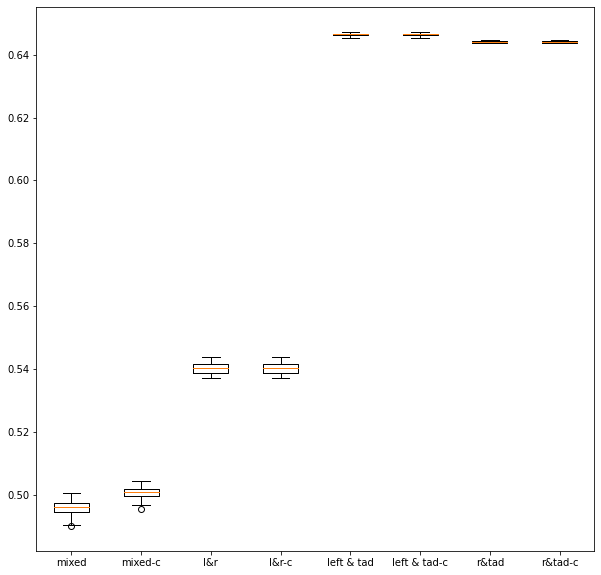

In [ ]:
import matplotlib

matplotlib.rc('figure', figsize=(10, 10))
my_dict11 = {'mixed': mean_roc1, 'mixed-c': mean_roc2,'l&r': mean_roc3, 'l&r-c': mean_roc4,'left & tad': mean_roc5, 'left & tad-c': mean_roc6,'r&tad': mean_roc7, 'r&tad-c': mean_roc8
             }
fig, ax = plt.subplots()
ax.boxplot(my_dict11.values())
ax.set_xticklabels(my_dict11.keys())

[Text(0, 0, 'mixed'),
 Text(0, 0, 'mixed-c'),
 Text(0, 0, 'left & right'),
 Text(0, 0, 'left & right- c'),
 Text(0, 0, 'left & tad'),
 Text(0, 0, 'left & tad-c'),
 Text(0, 0, 'right & tad'),
 Text(0, 0, 'right & tad-c')]

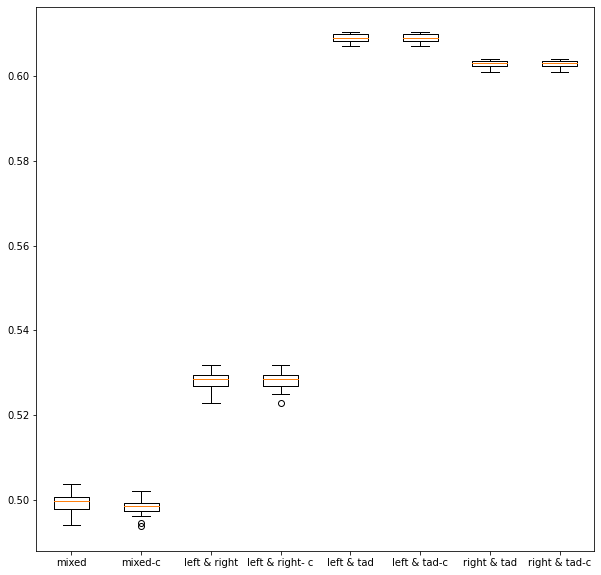

In [ ]:
my_dict11 = {'mixed': mean_acc1, 'mixed-c': mean_acc2,'left & right': mean_acc3, 'left & right- c': mean_acc4,'left & tad': mean_acc5, 'left & tad-c': mean_acc6,'right & tad': mean_acc7, 'right & tad-c': mean_acc8
             }
labels1=['mixed', 'mixed-c','left & right', 'left & right- c','left & tad', 'left & tad-c','right & tad', 'right & tad-c']
fig, ax = plt.subplots()
ax.boxplot(my_dict11.values(),labels =labels1)
ax.set_xticklabels(my_dict11.keys())